In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
import random as rd
import plotly.express as px

Before we get started, we import the dataset to be analysed and learn a bit about it.
Since we have the water quality data for the year 2014, we'll focus on the 2014 production here

In [2]:
df = pd.read_csv("apy.csv")
df_2014 = df[df["Crop_Year"] == 2014]
df_2014.head()

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
927,Andhra Pradesh,ANANTAPUR,2014,Kharif,Arhar/Tur,37562.0,4845.0
928,Andhra Pradesh,ANANTAPUR,2014,Kharif,Bajra,1752.0,1028.0
929,Andhra Pradesh,ANANTAPUR,2014,Kharif,Brinjal,320.0,7596.0
930,Andhra Pradesh,ANANTAPUR,2014,Kharif,Cabbage,10.0,123.0
931,Andhra Pradesh,ANANTAPUR,2014,Kharif,Cashewnut,19.0,7.0


In [3]:
df_2014["Season"].unique()

array(['Kharif     ', 'Rabi       ', 'Whole Year ', 'Autumn     ',
       'Summer     ', 'Winter     '], dtype=object)

We'll cluster separately based on the seasons above

First, let's define a few helper functions we'll call throughout the notebook

## K Means Clustering

In [4]:
def k_means(k, dfa, n_iter):
    centroids = np.array([]).reshape(n, 0)
    for i in range(k):
        rand = rd.randint(0, m-1)
        centroids = np.c_[centroids, dfa[rand]]
        
    for i in range(n_iter):
        dist_mat = np.array([]).reshape(m, 0)
        for i in range(k):
            tempDist = np.sum((dfa-centroids[:, i])**2, axis=1)
            dist_mat = np.c_[dist_mat, tempDist]

        C = np.argmin(dist_mat, axis=1)+1

        Y={}
        for i in range(k):
            Y[i+1]=np.array([]).reshape(n,0)
        for i in range(m):
            Y[C[i]]=np.c_[Y[C[i]],dfa[i]]

        for i in range(k):
            Y[i+1]=Y[i+1].T

        for i in range(k):
            centroids[:,i]=np.mean(Y[i+1],axis=0)
        Output=Y
        
    return Output, centroids

In [5]:
def calc_wss(k, output, centroids):
    for i in range(k):
        c = i+1
        sum = 0
        sum += cost(c, centroids, output)
        
    return sum

def cost(n, centroids, output):
    center = centroids.T[n-1]
    dist = 0
    for i in range(output[n].shape[0]):
        dist += np.linalg.norm(center - output[n][i])
    return dist

In [6]:
def make_elbow_graph(dfa):
    for k in range(1, 5):
        output, centroids = k_means(k, dfa, 300)
        sum = calc_wss(k, output, centroids)
        k_scores[k] = sum

## DBSCAN

In [7]:
def dbscan(D, eps, MinPts):
    labels = [0]*len(D)
    C = 0
    
    for P in range(len(D)):
        if labels[P] != 0:
            continue
            
        NeighbourPts = regionQuery(D, P, eps)
        if len(NeighbourPts) < MinPts:
            labels[P] = -1
        else:
            C += 1
            growCluster(D, labels, P, NeighbourPts, C, eps, MinPts)
    
    return labels

In [8]:
def growCluster(D, labels, P, NeighbourPts, C, eps, MinPts):
    labels[P] = C
    i = 0
    while i < len(NeighbourPts):
        Pn = NeighbourPts[i]
        if labels[Pn] == -1:
            labels[Pn] = C
        elif labels[Pn] == 0:
            labels[Pn] = C
            PnNeighbours = regionQuery(D, Pn, eps)
            
            if len(PnNeighbours) >= MinPts:
                NeighbourPts += PnNeighbours
                
        i += 1

In [9]:
def regionQuery(D, P, eps):
    neighbours = []
    
    for Pn in range(len(D)):
        if np.linalg.norm(D[P] - D[Pn]) < eps:
            neighbours.append(Pn)
            
    return neighbours

## Other functions

In [44]:
def make_dfa(df):
    df_1 = df.groupby('State_Name', as_index=False).sum()
    df_1["Prod/Area"] = df_1["Production"]/df_1["Area"]
    dfa = df_1.drop(["State_Name", "Area", "Production"], axis=1)
    dfa = np.array(dfa)
    dfa, mu, sigma = normalize_data(dfa)
    return dfa, df_1

In [84]:
def plot_graph(k, dfa):
    output, centroids = k_means(k, dfa, 300)
    color=['red','blue', 'green' 'yellow']
    labels=['cluster1','cluster2', 'cluster3']
    for i in range(k):
        plt.plot(output[i+1][:,0],"*", c=color[i],label=labels[i])
    plt.xlabel('0')
    plt.legend()
    plt.show()
    return output

In [12]:
def make_clusters_k(k, output, dfa, df):
    for i in range(k):
        for j in range(output[i+1].shape[0]):
            a = output[i+1][j]
            for z in range(m):
                b = np.array(dfa[z])
                if(np.sum(a-b) == 0.0):
                    if i == 0:
                        cluster_1.append(z)
                    elif i == 1:
                        cluster_2.append(z)
                    
    clusters = {1:[], 2:[]}
    for i in range(len(cluster_1)):
        clusters[1].append(df.iloc[cluster_1[i]]["State_Name"])
    for i in range(len(cluster_2)):
        clusters[2].append(df.iloc[cluster_2[i]]["State_Name"])
        
    return clusters

In [86]:
def make_clusters_k3(k, output, dfa, df):
    for i in range(k):
        for j in range(output[i+1].shape[0]):
            a = output[i+1][j]
            for z in range(m):
                b = np.array(dfa[z])
                if(np.sum(a-b) == 0.0):
                    if i == 0:
                        cluster_1.append(z)
                    elif i == 1:
                        cluster_2.append(z)
                    elif i == 2:
                        cluster_3.append(z)
                    
    clusters = {1:[], 2:[]}
    for i in range(len(cluster_1)):
        clusters[1].append(df.iloc[cluster_1[i]]["State_Name"])
    for i in range(len(cluster_2)):
        clusters[2].append(df.iloc[cluster_2[i]]["State_Name"])
    for i in range(len(cluster_3)):
        clusters[3].append(df.iloc[cluster_3[i]]["State_Name"])
        
    return clusters

In [59]:
def make_map(clusters, season):
    df_loc = pd.read_csv("states.csv")

    for i in range(df_loc.shape[0]):
        state = df_loc.iloc[i]["State"].lower()
        for j in range(1, len(clusters)+1):
            for c in range(len(clusters[j])):
                temp = clusters[j][c].lower()
                if state == temp:
                    df_loc.set_value(i, "Cluster_db", j)
                    #print("match")

    df_loc = df_loc.dropna()
    fig = px.scatter_geo(df_loc,
                       lat="Latitude",
                       lon="Longitude",
                       color="Cluster_db")

    fig.update_layout(title="States "+str(season)+ " o/p") 

    fig.show()

In [32]:
def normalize_data(data):
    mu = np.mean(data, 0)
    sigma = np.std(data, 0)
    data_norm = (data-mu)/sigma
    return data_norm, mu, sigma

# Kharif Season

In [45]:
df_2014_kharif = df_2014[df_2014["Season"] == "Kharif     "]
df_2014_kharif.head()

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
927,Andhra Pradesh,ANANTAPUR,2014,Kharif,Arhar/Tur,37562.0,4845.0
928,Andhra Pradesh,ANANTAPUR,2014,Kharif,Bajra,1752.0,1028.0
929,Andhra Pradesh,ANANTAPUR,2014,Kharif,Brinjal,320.0,7596.0
930,Andhra Pradesh,ANANTAPUR,2014,Kharif,Cabbage,10.0,123.0
931,Andhra Pradesh,ANANTAPUR,2014,Kharif,Cashewnut,19.0,7.0


In [46]:
df_2014_kharif = df_2014_kharif.drop(["District_Name", "Crop_Year", "Season", "Crop"], axis=1) 
df_2014_kharif

,State_Name,Area,Production
927,Andhra Pradesh,37562.0,4845.0
928,Andhra Pradesh,1752.0,1028.0
929,Andhra Pradesh,320.0,7596.0
930,Andhra Pradesh,10.0,123.0
931,Andhra Pradesh,19.0,7.0
932,Andhra Pradesh,10320.0,5903.0
933,Andhra Pradesh,162.0,84.0
934,Andhra Pradesh,73734.0,103779.0
935,Andhra Pradesh,982.0,410.0
936,Andhra Pradesh,2799.0,11848.0


In [47]:
dfa_kharif, df_kharif = make_dfa(df_2014_kharif)
dfa_kharif

array([[-0.15568111],
       [-0.50394593],
       [ 0.06811587],
       [ 0.17401478],
       [-0.47399809],
       [-0.47676677],
       [-0.37731626],
       [-0.52520854],
       [-0.4541977 ],
       [-0.55651516],
       [-0.09285238],
       [-0.39850555],
       [ 4.0936202 ],
       [-0.31443691],
       [-0.49242229],
       [-0.35452788],
       [-0.38259768],
       [ 0.65478923],
       [-0.0088723 ],
       [ 0.57730447]])

In [48]:
m = dfa_kharif.shape[0]
n = dfa_kharif.shape[1]

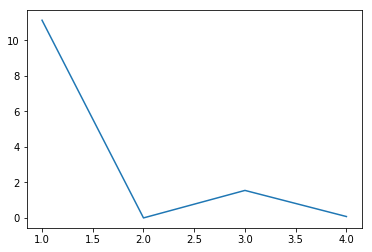

In [50]:
k_scores ={}
make_elbow_graph(dfa_kharif)
sns.lineplot(x=list(k_scores.keys()), y=list(k_scores.values()))

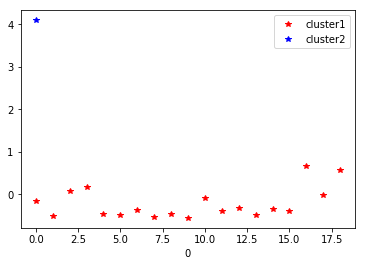

In [52]:
output = plot_graph(2, dfa_kharif)

In [54]:
cluster_1 = []
cluster_2 = []
clusters = make_clusters_k(2, output, dfa_kharif, df_kharif)
clusters

{1: ['Andhra Pradesh',
  'Arunachal Pradesh',
  'Assam',
  'Bihar',
  'Chhattisgarh',
  'Dadra and Nagar Haveli',
  'Goa',
  'Jammu and Kashmir ',
  'Karnataka',
  'Maharashtra',
  'Meghalaya',
  'Nagaland',
  'Punjab',
  'Sikkim',
  'Telangana ',
  'Tripura',
  'Uttar Pradesh',
  'Uttarakhand',
  'West Bengal'],
 2: ['Puducherry']}

In [60]:
make_map(clusters, "Kharif")

C:\Users\rushi\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



In [61]:
cluster_labels = dbscan(dfa_kharif, 3, 0.15)
cluster_labels

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]

In [62]:
clusters_db = {1: [], 2: []}
for i in range(len(cluster_labels)):
    x = cluster_labels[i]
    clusters_db[x].append(df_kharif.iloc[i]["State_Name"])
clusters_db

{1: ['Andhra Pradesh',
  'Arunachal Pradesh',
  'Assam',
  'Bihar',
  'Chhattisgarh',
  'Dadra and Nagar Haveli',
  'Goa',
  'Jammu and Kashmir ',
  'Karnataka',
  'Maharashtra',
  'Meghalaya',
  'Nagaland',
  'Punjab',
  'Sikkim',
  'Telangana ',
  'Tripura',
  'Uttar Pradesh',
  'Uttarakhand',
  'West Bengal'],
 2: ['Puducherry']}

In [63]:
make_map(clusters_db, "Kharif")

C:\Users\rushi\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



The results given by both K means and DBSCAN are the same, so we can proceed with either result

# Rabi Season

In [64]:
df_2014_rabi = df_2014[df_2014["Season"] == "Rabi       "]
df_2014_rabi.head()

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
963,Andhra Pradesh,ANANTAPUR,2014,Rabi,Bajra,47.0,28.0
964,Andhra Pradesh,ANANTAPUR,2014,Rabi,Brinjal,468.0,11108.0
965,Andhra Pradesh,ANANTAPUR,2014,Rabi,Cabbage,2.0,25.0
966,Andhra Pradesh,ANANTAPUR,2014,Rabi,Castor seed,229.0,131.0
967,Andhra Pradesh,ANANTAPUR,2014,Rabi,Coriander,8223.0,4251.0


In [65]:
df_2014_rabi = df_2014_rabi.drop(["District_Name", "Crop_Year", "Season", "Crop"], axis=1) 
df_2014_rabi

,State_Name,Area,Production
963,Andhra Pradesh,47.0,28.0
964,Andhra Pradesh,468.0,11108.0
965,Andhra Pradesh,2.0,25.0
966,Andhra Pradesh,229.0,131.0
967,Andhra Pradesh,8223.0,4251.0
968,Andhra Pradesh,884.0,1244.0
969,Andhra Pradesh,234.0,263.0
970,Andhra Pradesh,124.0,387.0
971,Andhra Pradesh,68092.0,38676.0
972,Andhra Pradesh,14957.0,24679.0


In [66]:
dfa_rabi, df_rabi = make_dfa(df_2014_rabi)
dfa_rabi

array([[ 0.34380497],
       [-0.20319785],
       [-0.37163967],
       [-0.30967187],
       [-0.63206072],
       [-0.22230163],
       [-0.15531173],
       [-0.59206189],
       [-0.71204535],
       [-0.58147171],
       [-0.30776152],
       [ 0.22262362],
       [ 0.79957473],
       [-0.69435803],
       [ 0.39418873],
       [-0.71310397],
       [ 0.14335805],
       [-0.27048753],
       [ 3.86192336]])

In [67]:
m = dfa_rabi.shape[0]
n = dfa_rabi.shape[1]

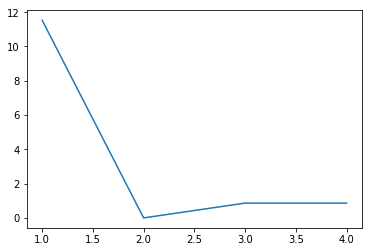

In [69]:
k_scores ={}
make_elbow_graph(dfa_rabi)
sns.lineplot(x=list(k_scores.keys()), y=list(k_scores.values()))

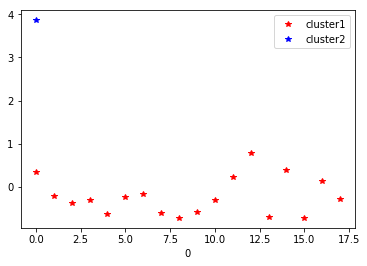

In [70]:
output = plot_graph(2, dfa_rabi)

In [71]:
cluster_1 = []
cluster_2 = []
clusters = make_clusters_k(2, output, dfa_rabi, df_rabi)
clusters

{1: ['Andhra Pradesh',
  'Arunachal Pradesh',
  'Assam',
  'Bihar',
  'Chhattisgarh',
  'Dadra and Nagar Haveli',
  'Goa',
  'Karnataka',
  'Maharashtra',
  'Meghalaya',
  'Nagaland',
  'Puducherry',
  'Punjab',
  'Sikkim',
  'Telangana ',
  'Tripura',
  'Uttar Pradesh',
  'Uttarakhand'],
 2: ['West Bengal']}

In [72]:
make_map(clusters, "Rabi")

C:\Users\rushi\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



In [73]:
cluster_labels = dbscan(dfa_rabi, 3, 0.15)
cluster_labels

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]

In [75]:
clusters_db = {1: [], 2: []}
for i in range(len(cluster_labels)):
    x = cluster_labels[i]
    clusters_db[x].append(df_rabi.iloc[i]["State_Name"])
clusters_db

{1: ['Andhra Pradesh',
  'Arunachal Pradesh',
  'Assam',
  'Bihar',
  'Chhattisgarh',
  'Dadra and Nagar Haveli',
  'Goa',
  'Karnataka',
  'Maharashtra',
  'Meghalaya',
  'Nagaland',
  'Puducherry',
  'Punjab',
  'Sikkim',
  'Telangana ',
  'Tripura',
  'Uttar Pradesh',
  'Uttarakhand'],
 2: ['West Bengal']}

In [76]:
make_map(clusters_db, "Rabi")

C:\Users\rushi\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



Even here, we get the same result from both K means and DBSCAN

# Autumn Season

In [77]:
df_2014_aut = df_2014[df_2014["Season"] == "Autumn     "]
df_2014_aut.head()

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
12691,Assam,BAKSA,2014,Autumn,Paddy,10800.0,18283.0
12692,Assam,BAKSA,2014,Autumn,Rice,10800.0,18283.0
13283,Assam,BARPETA,2014,Autumn,Paddy,17551.0,18634.0
13284,Assam,BARPETA,2014,Autumn,Rice,17551.0,18634.0
13870,Assam,BONGAIGAON,2014,Autumn,Paddy,5865.0,7909.0


In [78]:
df_2014_aut = df_2014_aut.drop(["District_Name", "Crop_Year", "Season", "Crop"], axis=1) 
df_2014_aut

,State_Name,Area,Production
12691,Assam,10800.0,18283.0
12692,Assam,10800.0,18283.0
13283,Assam,17551.0,18634.0
13284,Assam,17551.0,18634.0
13870,Assam,5865.0,7909.0
13871,Assam,5865.0,7909.0
14445,Assam,6752.0,13796.0
14446,Assam,6752.0,13796.0
14794,Assam,6255.0,6553.0
14795,Assam,6255.0,6553.0


In [91]:
dfa_aut, df_aut = make_dfa(df_2014_aut)
df_aut

,State_Name,Area,Production,Prod/Area
0,Assam,392376.0,561386.0,1.430735
1,Bihar,858544.0,1835487.0,2.137907
2,Kerala,63981.0,161477.0,2.523827
3,Meghalaya,33102.0,76631.0,2.314996
4,Odisha,757572.0,1263397.5,1.667693
5,West Bengal,287541.0,728054.0,2.532001


In [92]:
m = dfa_aut.shape[0]
n = dfa_aut.shape[1]

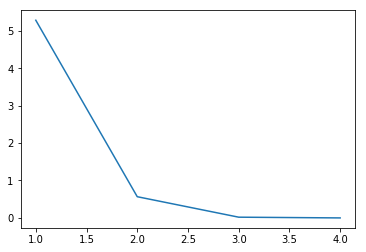

In [93]:
k_scores ={}
make_elbow_graph(dfa_aut)
sns.lineplot(x=list(k_scores.keys()), y=list(k_scores.values()))

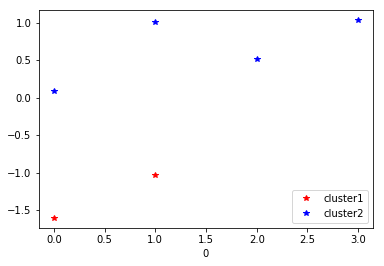

In [94]:
output = plot_graph(2, dfa_aut)

In [95]:
cluster_1 = []
cluster_2 = []
clusters = make_clusters_k(2, output, dfa_aut, df_aut)
clusters

{1: ['Assam', 'Odisha'], 2: ['Bihar', 'Kerala', 'Meghalaya', 'West Bengal']}

In [96]:
make_map(clusters, "Autumn")

C:\Users\rushi\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



In [102]:
cluster_labels = dbscan(dfa_aut, 1, 0.08)
cluster_labels

[1, 2, 2, 2, 1, 2]

In [103]:
clusters_db = {1: [], 2: []}
for i in range(len(cluster_labels)):
    x = cluster_labels[i]
    clusters_db[x].append(df_aut.iloc[i]["State_Name"])
clusters_db

{1: ['Assam', 'Odisha'], 2: ['Bihar', 'Kerala', 'Meghalaya', 'West Bengal']}

In [104]:
make_map(clusters_db, "Autumn")

C:\Users\rushi\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



Even here, we get the same result from both K means and DBSCAN

# Summer Season

In [105]:
df_2014_sum = df_2014[df_2014["Season"] == "Summer     "]
df_2014_sum.head()

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
12719,Assam,BAKSA,2014,Summer,Paddy,3050.0,6509.0
12720,Assam,BAKSA,2014,Summer,Rice,3050.0,6509.0
13311,Assam,BARPETA,2014,Summer,Paddy,49261.0,141830.0
13312,Assam,BARPETA,2014,Summer,Rice,49261.0,141830.0
13897,Assam,BONGAIGAON,2014,Summer,Paddy,11685.0,38969.0


In [106]:
df_2014_sum = df_2014_sum.drop(["District_Name", "Crop_Year", "Season", "Crop"], axis=1) 
df_2014_sum

,State_Name,Area,Production
12719,Assam,3050.0,6509.0
12720,Assam,3050.0,6509.0
13311,Assam,49261.0,141830.0
13312,Assam,49261.0,141830.0
13897,Assam,11685.0,38969.0
13898,Assam,11685.0,38969.0
14472,Assam,8235.0,16088.0
14473,Assam,8235.0,16088.0
14821,Assam,3413.0,8114.0
14822,Assam,3413.0,8114.0


In [107]:
dfa_sum, df_sum = make_dfa(df_2014_sum)
dfa_sum

array([[-0.18624401],
       [-0.38970726],
       [-0.47004038],
       [-0.06846467],
       [-0.64440962],
       [ 3.11705529],
       [-0.48860797],
       [-0.27778147],
       [-0.32115431],
       [-0.11466217],
       [-0.15598341]])

In [108]:
m = dfa_sum.shape[0]
n = dfa_sum.shape[1]

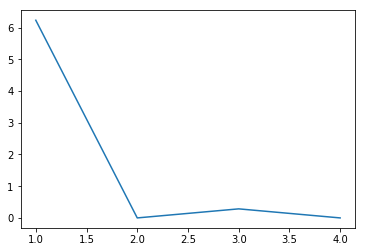

In [110]:
k_scores ={}
make_elbow_graph(dfa_sum)
sns.lineplot(x=list(k_scores.keys()), y=list(k_scores.values()))

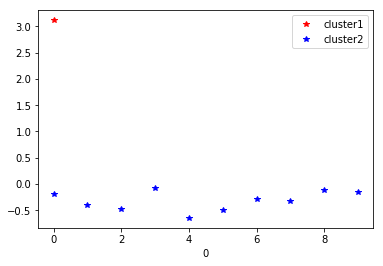

In [111]:
output = plot_graph(2, dfa_sum)

In [112]:
cluster_1 = []
cluster_2 = []
clusters = make_clusters_k(2, output, dfa_sum, df_sum)
clusters

{1: ['Meghalaya'],
 2: ['Assam',
  'Bihar',
  'Karnataka',
  'Kerala',
  'Maharashtra',
  'Odisha',
  'Puducherry',
  'Uttar Pradesh',
  'Uttarakhand',
  'West Bengal']}

In [113]:
make_map(clusters, "Summer")

C:\Users\rushi\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



In [114]:
cluster_labels = dbscan(dfa_sum, 1, 0.1)
cluster_labels

[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1]

In [115]:
clusters_db = {1: [], 2: []}
for i in range(len(cluster_labels)):
    x = cluster_labels[i]
    clusters_db[x].append(df_sum.iloc[i]["State_Name"])
clusters_db

{1: ['Assam',
  'Bihar',
  'Karnataka',
  'Kerala',
  'Maharashtra',
  'Odisha',
  'Puducherry',
  'Uttar Pradesh',
  'Uttarakhand',
  'West Bengal'],
 2: ['Meghalaya']}

In [116]:
make_map(clusters_db, "Summer")

C:\Users\rushi\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



K means and DBSCAN give same result

# Winter Season

In [117]:
df_2014_win = df_2014[df_2014["Season"] == "Winter     "]
df_2014_win.head()

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
12726,Assam,BAKSA,2014,Winter,Paddy,86070.0,195027.0
12727,Assam,BAKSA,2014,Winter,Rice,86070.0,195027.0
13318,Assam,BARPETA,2014,Winter,Paddy,69154.0,102046.0
13319,Assam,BARPETA,2014,Winter,Rice,69154.0,102046.0
13904,Assam,BONGAIGAON,2014,Winter,Paddy,35299.0,69061.0


In [118]:
df_2014_win = df_2014_win.drop(["District_Name", "Crop_Year", "Season", "Crop"], axis=1) 
df_2014_win

,State_Name,Area,Production
12726,Assam,86070.0,195027.0
12727,Assam,86070.0,195027.0
13318,Assam,69154.0,102046.0
13319,Assam,69154.0,102046.0
13904,Assam,35299.0,69061.0
13905,Assam,35299.0,69061.0
14479,Assam,92895.0,216009.0
14480,Assam,92895.0,216009.0
14828,Assam,35857.0,58189.0
14829,Assam,35857.0,58189.0


In [119]:
dfa_win, df_win = make_dfa(df_2014_win)
df_win

,State_Name,Area,Production,Prod/Area
0,Assam,3765512.0,7435812.0,1.974715
1,Bihar,2599981.0,7049728.0,2.711454
2,Dadra and Nagar Haveli,174.0,324.0,1.862069
3,Kerala,88990.0,254450.0,2.859310
4,Meghalaya,69639.0,201877.0,2.898907
5,Odisha,3558735.0,8728644.3,2.452738
6,West Bengal,4009787.0,10984799.0,2.739497


In [120]:
m = dfa_win.shape[0]
n = dfa_win.shape[1]

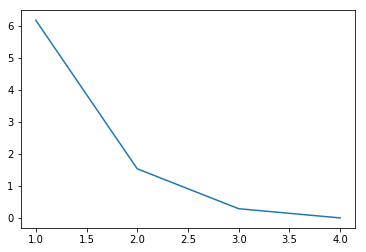

In [130]:
k_scores ={}
make_elbow_graph(dfa_win)
sns.lineplot(x=list(k_scores.keys()), y=list(k_scores.values()))

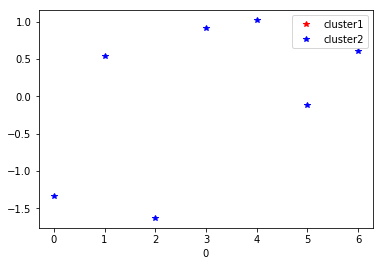

In [131]:
output = plot_graph(2, dfa_win)

In [132]:
cluster_1 = []
cluster_2 = []
clusters = make_clusters_k(2, output, dfa_win, df_win)
clusters

{1: [],
 2: ['Assam',
  'Bihar',
  'Dadra and Nagar Haveli',
  'Kerala',
  'Meghalaya',
  'Odisha',
  'West Bengal']}

In [133]:
make_map(clusters, "Winter")

C:\Users\rushi\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



In [134]:
cluster_labels = dbscan(dfa_win, 1, 0.08)
cluster_labels

[1, 2, 1, 2, 2, 2, 2]

In [135]:
clusters_db = {1: [], 2: []}
for i in range(len(cluster_labels)):
    x = cluster_labels[i]
    clusters_db[x].append(df_win.iloc[i]["State_Name"])
clusters_db

{1: ['Assam', 'Dadra and Nagar Haveli'],
 2: ['Bihar', 'Kerala', 'Meghalaya', 'Odisha', 'West Bengal']}

In [136]:
make_map(clusters_db, "Winter")

C:\Users\rushi\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



Here DBSCAN appears to do a better job, so we'll choose that over the output of K means

# Whole Year

In [137]:
df_2014_year = df_2014[df_2014["Season"] == "Whole Year "]
df_2014_year.head()

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
989,Andhra Pradesh,ANANTAPUR,2014,Whole Year,Coconut,687.0,5756000.0
990,Andhra Pradesh,ANANTAPUR,2014,Whole Year,Rice,29211.0,82532.0
1778,Andhra Pradesh,CHITTOOR,2014,Whole Year,Coconut,3465.0,29033000.0
1779,Andhra Pradesh,CHITTOOR,2014,Whole Year,Rice,40965.0,132424.0
2543,Andhra Pradesh,EAST GODAVARI,2014,Whole Year,Coconut,46865.0,780162000.0


In [138]:
df_2014_year = df_2014_year.drop(["District_Name", "Crop_Year", "Season", "Crop"], axis=1) 
df_2014_year

,State_Name,Area,Production
989,Andhra Pradesh,687.0,5756000.0
990,Andhra Pradesh,29211.0,82532.0
1778,Andhra Pradesh,3465.0,29033000.0
1779,Andhra Pradesh,40965.0,132424.0
2543,Andhra Pradesh,46865.0,780162000.0
2544,Andhra Pradesh,394117.0,1563229.0
3230,Andhra Pradesh,112.0,2428000.0
3231,Andhra Pradesh,285302.0,1111932.0
4054,Andhra Pradesh,121.0,1014000.0
4055,Andhra Pradesh,45885.0,165837.0


In [139]:
dfa_year, df_year = make_dfa(df_2014_year)
df_year

,State_Name,Area,Production,Prod/Area
0,Andhra Pradesh,2493060.00,2.100125e+09,842.388304
1,Arunachal Pradesh,53265.00,1.818500e+05,3.414062
2,Assam,210227.00,2.796898e+06,13.304181
3,Bihar,264931.00,1.551762e+07,58.572308
4,Chhattisgarh,39862.00,1.881920e+05,4.721088
5,Goa,104531.00,2.511020e+05,2.402177
6,Karnataka,1423663.00,5.130120e+07,36.034649
7,Kerala,1219986.06,5.950801e+09,4877.761107
8,Maharashtra,1029500.00,9.153810e+07,88.915104
9,Meghalaya,50072.00,1.032950e+05,2.062929


In [140]:
m = dfa_year.shape[0]
n = dfa_year.shape[1]

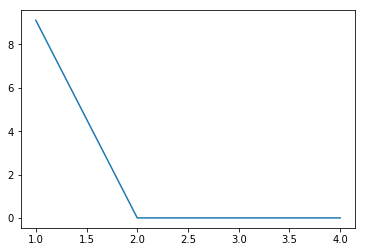

In [143]:
k_scores ={}
make_elbow_graph(dfa_year)
sns.lineplot(x=list(k_scores.keys()), y=list(k_scores.values()))

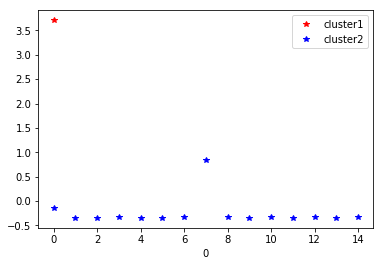

In [144]:
output = plot_graph(2, dfa_year)

In [145]:
cluster_1 = []
cluster_2 = []
clusters = make_clusters_k(2, output, dfa_year, df_year)
clusters

{1: ['Puducherry'],
 2: ['Andhra Pradesh',
  'Arunachal Pradesh',
  'Assam',
  'Bihar',
  'Chhattisgarh',
  'Goa',
  'Karnataka',
  'Kerala',
  'Maharashtra',
  'Meghalaya',
  'Punjab',
  'Telangana ',
  'Tripura',
  'Uttarakhand',
  'West Bengal']}

In [146]:
make_map(clusters, "Whole Year")

C:\Users\rushi\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



In [149]:
cluster_labels = dbscan(dfa_year, 2, 0.06)
cluster_labels

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1]

In [150]:
clusters_db = {1: [], 2: []}
for i in range(len(cluster_labels)):
    x = cluster_labels[i]
    clusters_db[x].append(df_year.iloc[i]["State_Name"])
clusters_db

{1: ['Andhra Pradesh',
  'Arunachal Pradesh',
  'Assam',
  'Bihar',
  'Chhattisgarh',
  'Goa',
  'Karnataka',
  'Kerala',
  'Maharashtra',
  'Meghalaya',
  'Punjab',
  'Telangana ',
  'Tripura',
  'Uttarakhand',
  'West Bengal'],
 2: ['Puducherry']}

In [151]:
make_map(clusters_db, "Whole Year")

C:\Users\rushi\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



Same output from K means and DBSCAN